# Deep Q Network

前面的章节我们的Q都是用字典来表示的，也就是一种穷举法。可是当Q中元素非常多时，计算量会非常庞大。  
考虑到神经网络有非常强大的非线性能力，因此，我们可以将Q function看成是一个Q[s, a]=f(s)这样的的复杂非线性函数，然后用神经网络来表示Q function。这就是Deep Q Network算法。  
用神经网络近似后的Q function我们称之为Q Network.

In [2]:
import random
import gym
import numpy as np
import collections
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')

In [3]:
#定义缓存(replay buffer)

class Replay_Buffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) #创建一个长度不会大于capacity的列表，当存满了之后新数据会顶掉老数据
     
    #将数据存入buffer
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size) #从buffer中随机采样，数量为batch_size,返回数据类型为列表
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done
    
    #统计buffer存储的样本数
    def size(self):
        return len(self.buffer)

In [4]:
#定义Q Network

class Q_net(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Q_net, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        
    def forward(self, x):
        y_hat = F.relu(self.fc1(x))
        y_hat = self.fc2(y_hat)
        return y_hat

In [5]:
#实现DQN算法

class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update):
        self.action_dim = action_dim
        
        #定义Q network
        self.q_net = Q_net(state_dim, hidden_dim, self.action_dim)
        
        #定义目标网络
        self.target_q_net = Q_net(state_dim, hidden_dim, self.action_dim)
        
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr = learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update #目标网络更新频率
        self.count = 0 #记录更新次数
        
    def take_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            action = np.random.randint(self.action_dim)
            
        else:
            state = torch.tensor([state], dtype=torch.float)
            action = self.q_net(state).argmax().item()
        return action
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1)
        
        q_values = self.q_net(states).gather(1, actions)  # Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()
        
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [8]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 1000
minimal_size = 500
batch_size = 64

random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = Replay_Buffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update)

return_list = []
for i_episode in range(int(num_episodes)):
    episode_return = 0
    state = env.reset()
    done = False
    while not done:
        action = agent.take_action(state)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        episode_return += reward
        # 当buffer数据的数量超过一定值后,才进行Q网络训练
        if replay_buffer.size() > minimal_size:
            b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
            transition_dict = {
                'states': b_s,
                'actions': b_a,
                'next_states': b_ns,
                'rewards': b_r,
                'dones': b_d
            }
            agent.update(transition_dict)
    return_list.append(episode_return)

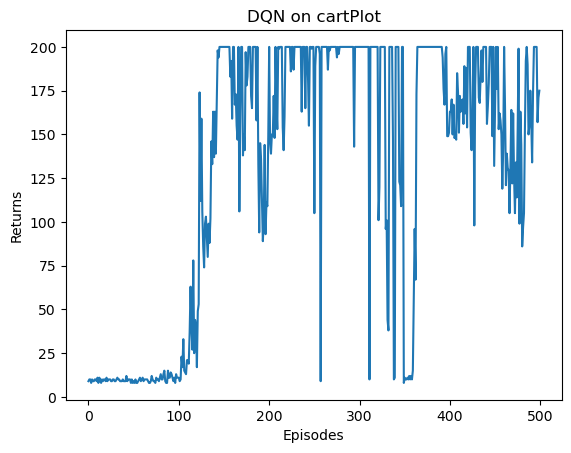

In [9]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format('cartPlot'))
plt.show()

